# Lab | Customer Analysis Final Round

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pandas.plotting import scatter_matrix
import seaborn as sns
from IPython.display import set_matplotlib_formats, HTML
from matplotlib.dates import DateFormatter
import matplotlib_inline 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import colors as mcolors
from pandas.plotting import register_matplotlib_converters
import plotly.express as px
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore') 

In [3]:
# Formating Plots
# default styles
def set_sns_format(width=14, height=8):
    sns.set_theme(palette='pastel', context='notebook',rc={'savefig.dpi':300})
    matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
    matplotlib.rcParams['figure.figsize'] = (width, height)
    return None
set_sns_format(width=14, height=8)

In [4]:
def add_value_labels(ax, typ, spacing=5):
    #This function add the labels in the bar and line plots
    #input the ax to add the labels, the type of plot
    
    space = spacing
    va = 'bottom'
    

    if typ == 'bar':
        for i in ax.patches:
            y_value = i.get_height()
            x_value = i.get_x() + i.get_width() / 2

            label = "{:.2f}".format(y_value)
            ax.annotate(label,(x_value, y_value), xytext=(0, space), 
                    textcoords="offset points", ha='center', va=va, fontsize=10)     

    if typ == 'line':
        for line in ax.lines:
            for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
                label = "{:.2f}".format(y_value)
                ax.annotate(label,(x_value, y_value), xytext=(0, space), 
                    textcoords="offset points", ha='center', va=va, fontsize=10)

In [1]:
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression

## 2 Getting the Data   

In [5]:
df = pd.read_csv(r'C:\Users\ssai\OneDrive\Data_26-07\labs\lab-customer-analysis-final-round\files_for_lab\csv_files/marketing_customer_analysis.csv') 

### 3 - Cleannig the Data | Exploratory Data Analysis

In [7]:
df.info() # Checking Dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

In [9]:
df.isna().sum().sort_values(ascending=False) # Checking NAN

Customer                         0
State                            0
Vehicle Class                    0
Total Claim Amount               0
Sales Channel                    0
Renew Offer Type                 0
Policy                           0
Policy Type                      0
Number of Policies               0
Number of Open Complaints        0
Months Since Policy Inception    0
Months Since Last Claim          0
Monthly Premium Auto             0
Marital Status                   0
Location Code                    0
Income                           0
Gender                           0
EmploymentStatus                 0
Effective To Date                0
Education                        0
Coverage                         0
Response                         0
Customer Lifetime Value          0
Vehicle Size                     0
dtype: int64

In [11]:
# Change Headers Taxonomy

df.columns = df.columns.str.lower() # All column headers in lower letters
df.columns = df.columns.str.replace(' ','_')    # repalce spaces inbetween with '_'



### Categorical vs Numerical 

In [13]:
categorical = df.select_dtypes(include=np.object)
categorical.columns.to_list()

['customer',
 'state',
 'response',
 'coverage',
 'education',
 'effective_to_date',
 'employmentstatus',
 'gender',
 'location_code',
 'marital_status',
 'policy_type',
 'policy',
 'renew_offer_type',
 'sales_channel',
 'vehicle_class',
 'vehicle_size']

In [14]:
numerical = df.select_dtypes(include=np.number)
numerical.columns.to_list()

['customer_lifetime_value',
 'income',
 'monthly_premium_auto',
 'months_since_last_claim',
 'months_since_policy_inception',
 'number_of_open_complaints',
 'number_of_policies',
 'total_claim_amount']

In [16]:
drop_columns = ['sales_channel', 'state', 'education', 'number_of_open_complaints'
               , 'months_since_policy_inception', 'vehicle_size', 'policy', 'months_since_last_claim']
df= df.drop(columns=drop_columns) # drop Columns

### 04 - Proccesing the Data

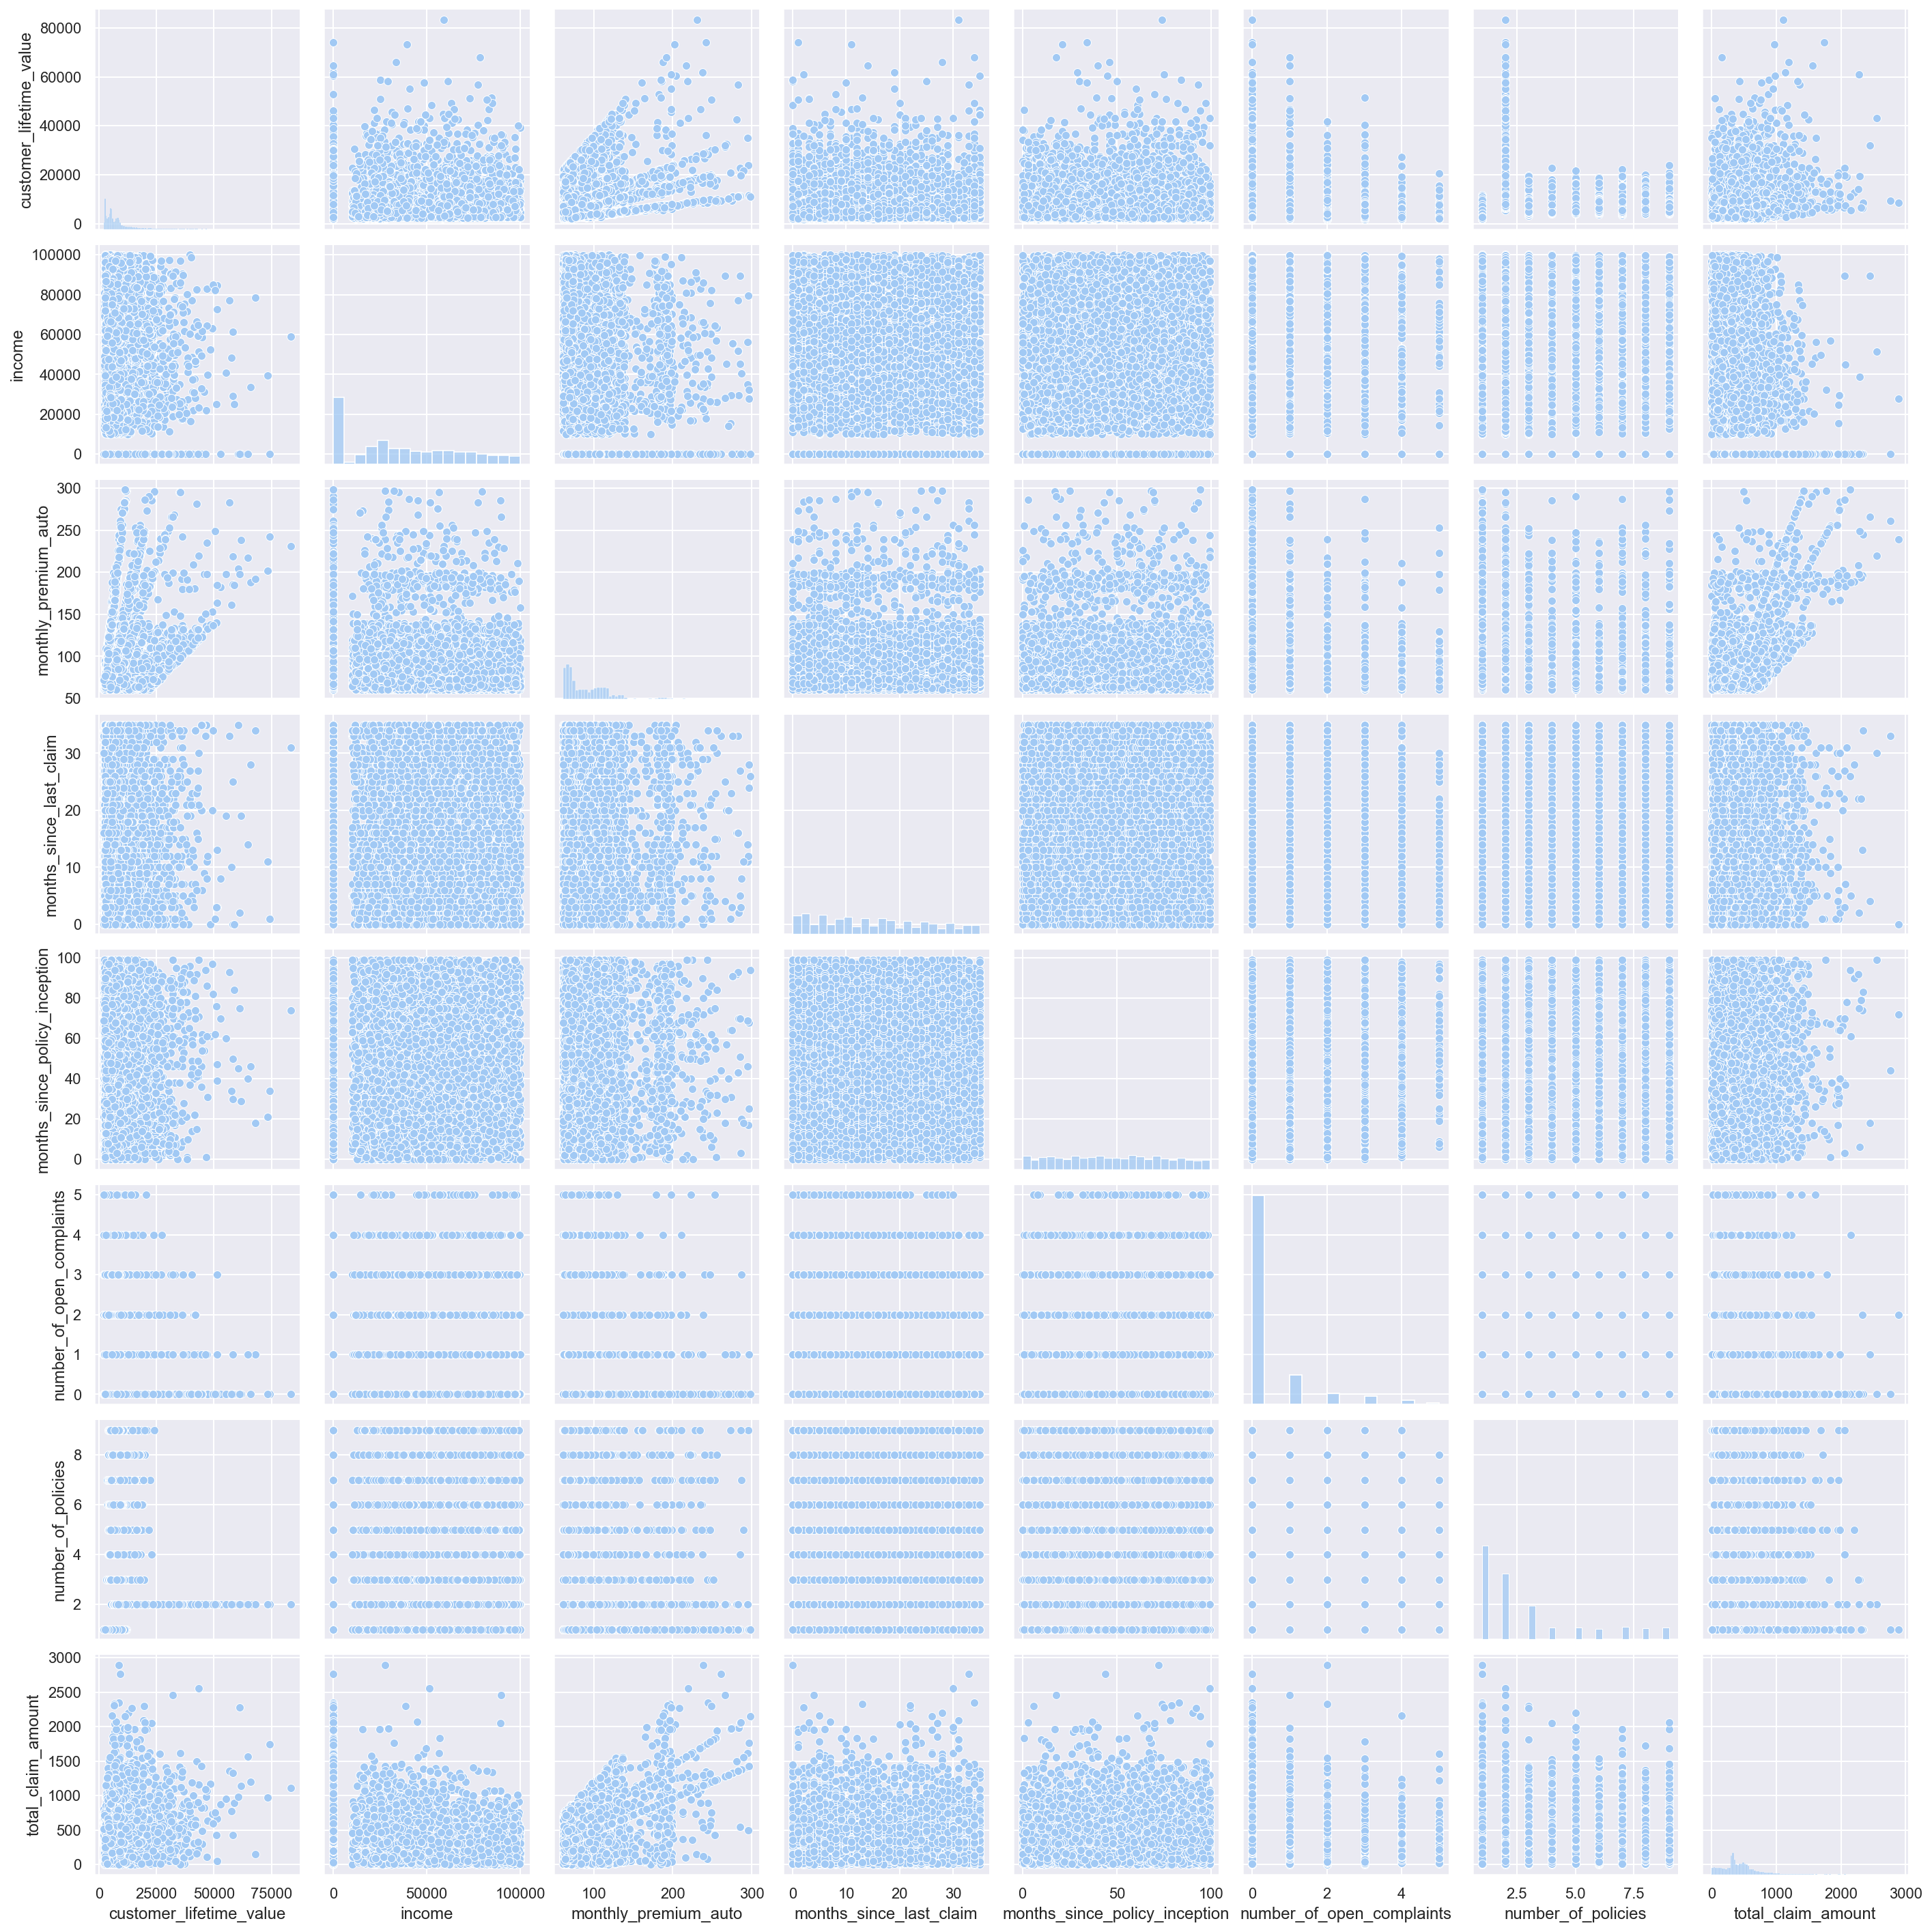

In [19]:
sns.pairplot(numerical)

### Oultiers

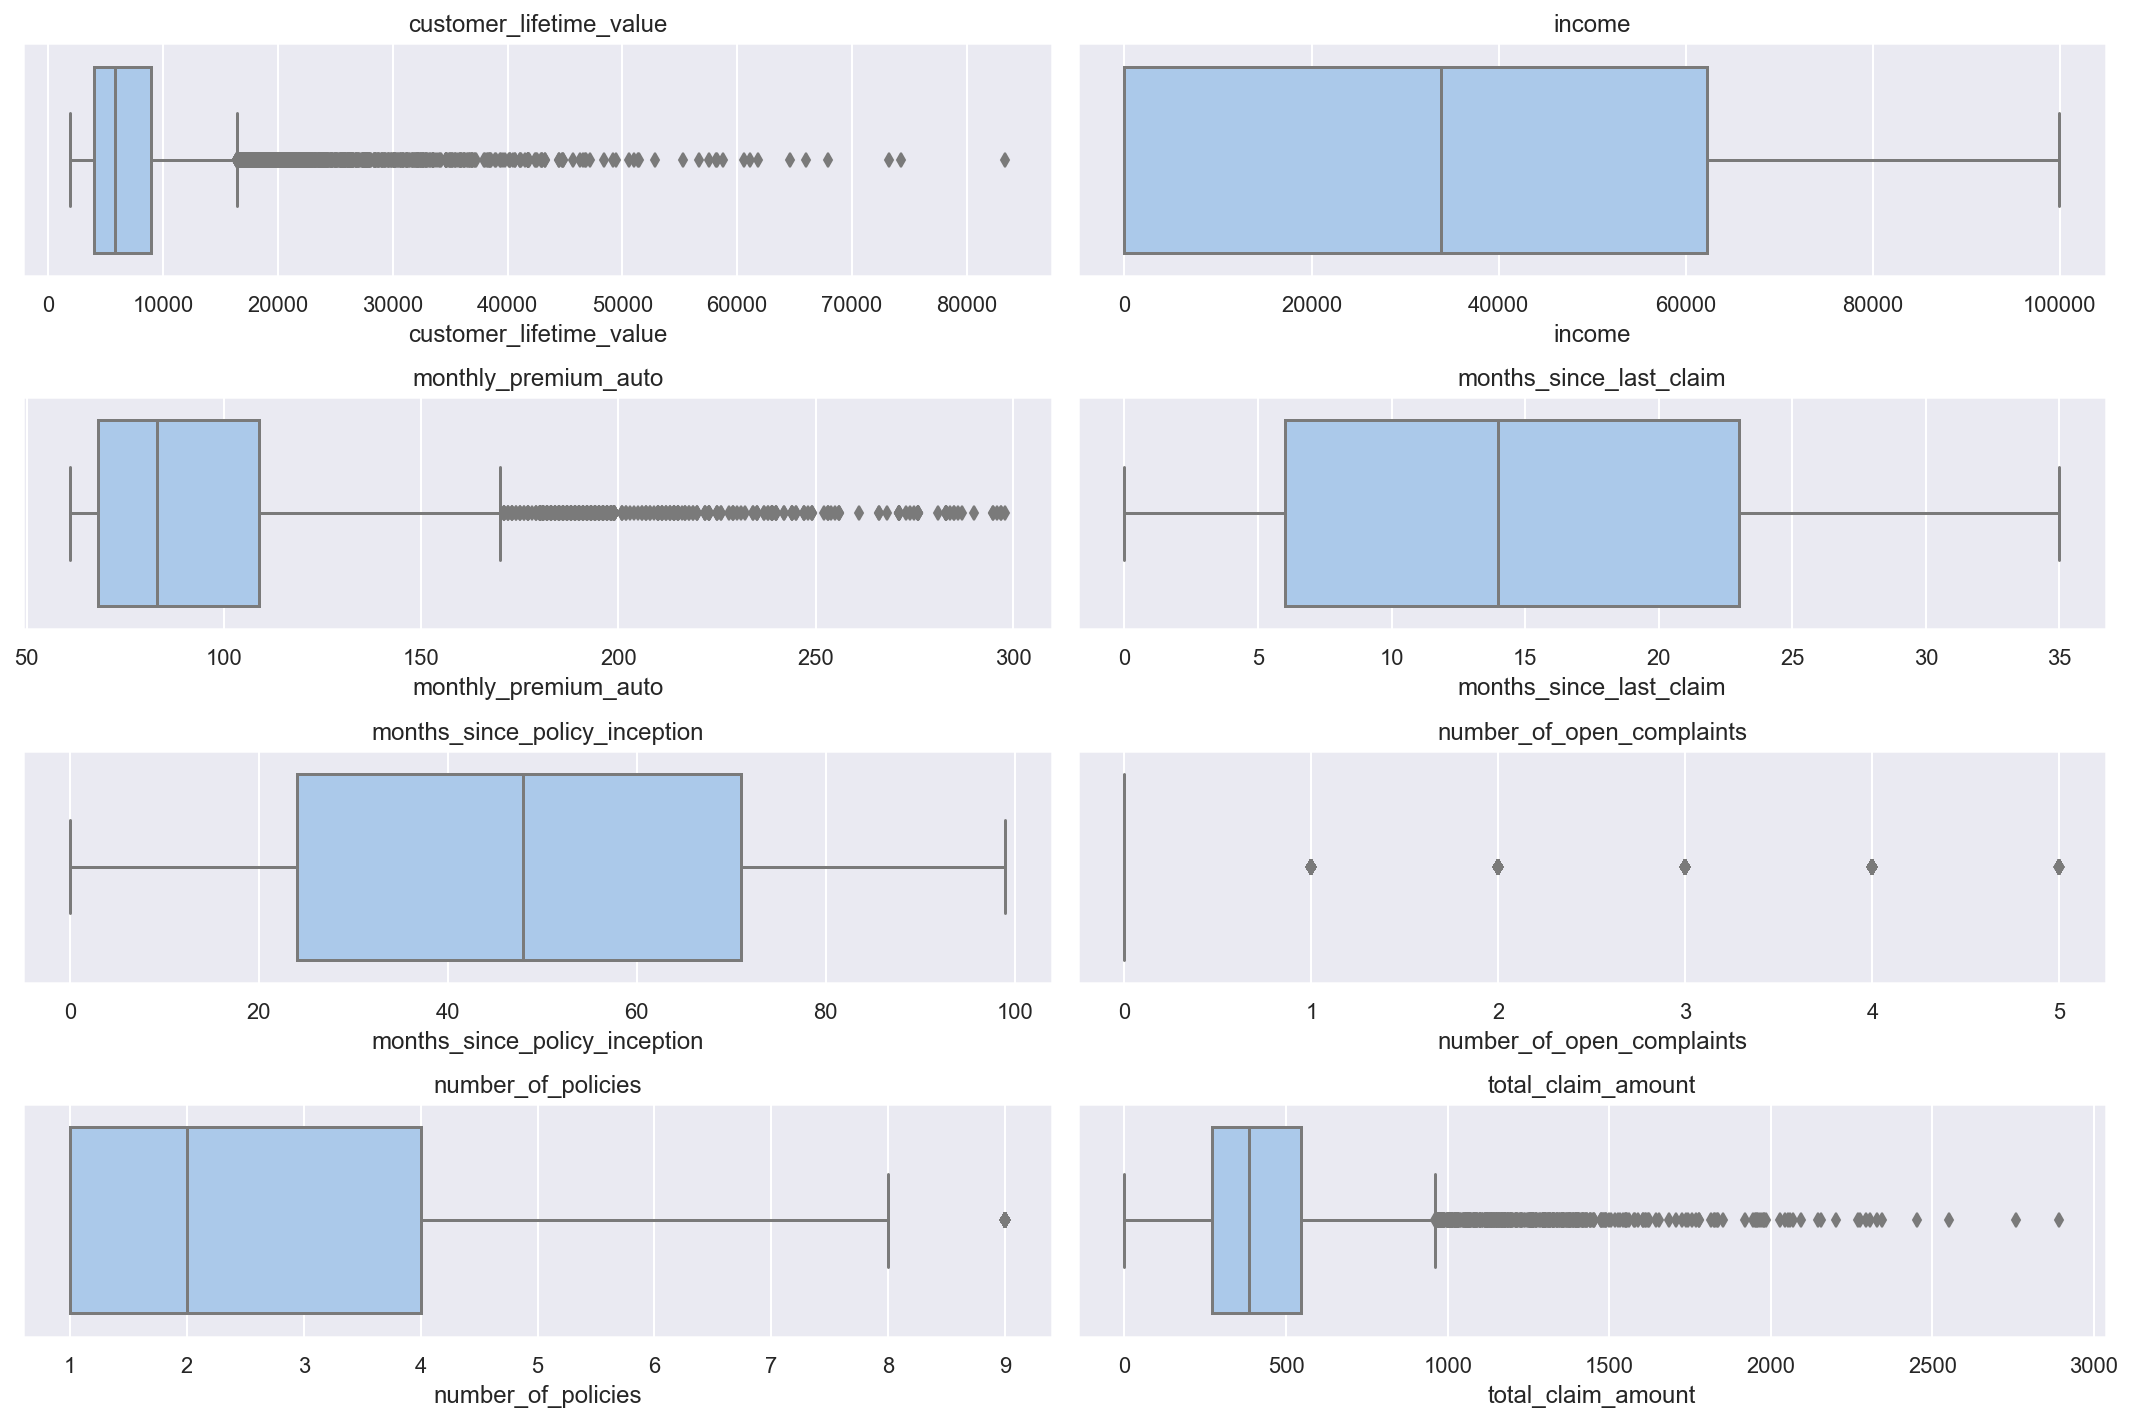

In [22]:
fig, axs = plt.subplots(4, 2, figsize=(15, 10))
axs = axs.flatten()

for i, item in enumerate(numerical.columns):
    sns.boxplot(x = numerical[item], ax=axs[i])
    axs[i].set_title(item)

plt.tight_layout()
plt.show()

(9134, 16)
(8718, 16)


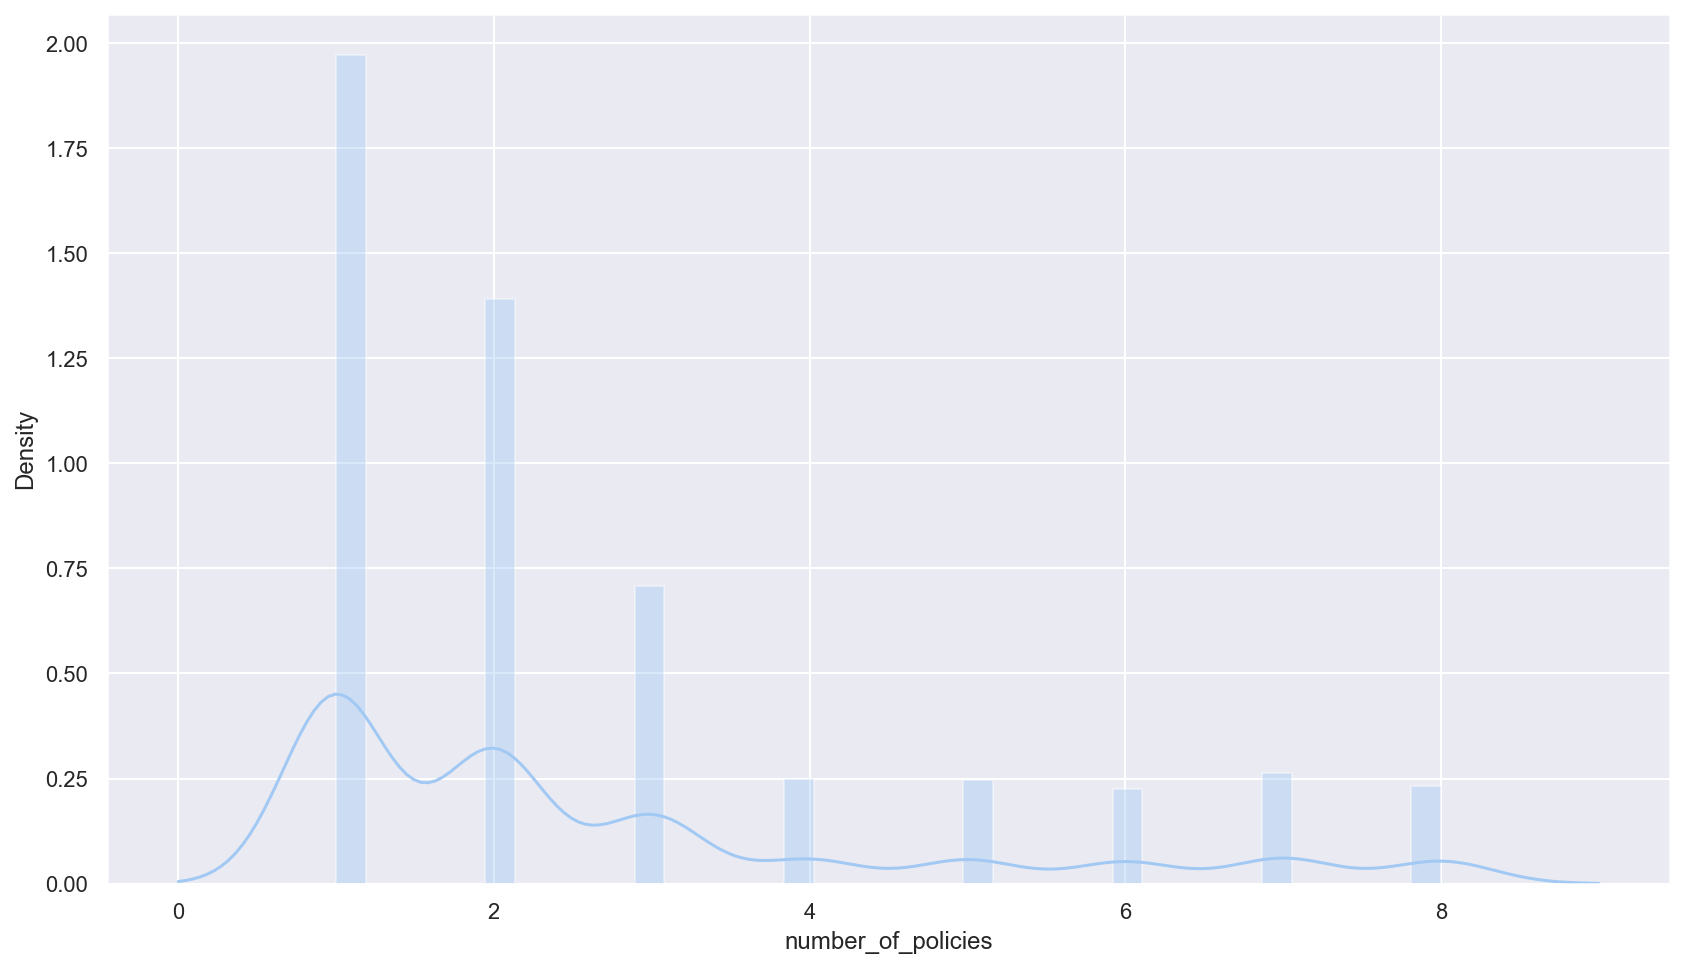

In [24]:
# Removing outliers for number_of_policies

columns_to_drop = ['number_of_policies'] 
for drop in columns_to_drop:             
    print(df.shape)                    
    
    Q1 = df.quantile(0.25) # first quantile
    Q3 = df.quantile(0.75) # third quantile
    IQR = Q3 - Q1            # inter quantile range

    df = df[~(                                 # negation so we get the datapoints within the whiskers
        (df[columns_to_drop] < (Q1 - 1.5 * IQR)) # datapoints left of the "left whisker"
        |(df[columns_to_drop] > (Q3 + 1.5 * IQR) # datapoints right of the 'right whisker'
        )).any(axis=1)]
    
    print(df.shape)                    # data frame shape after drops
    sns.distplot(df[drop])
    plt.show()

### Encoding Categorical Variables

In [26]:

split_feature = 'total_claim_amount'  
x = df[df.columns.drop(split_feature)] 
y = df[split_feature]                  

In [27]:
#There are two categorical columns that are too big to label.
   
x = x.drop('customer', axis =1)          
x = x.drop('effective_to_date', axis= 1)           

In [28]:
x = pd.get_dummies(x, drop_first = True) # dummification
x_features = x.columns.to_list()  

### Train Test Split

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42)

# Normalization

In [32]:
numerical_transformer = StandardScaler() 

In [33]:
X_train = numerical_transformer.fit_transform(X_train) 
X_test = numerical_transformer.transform(X_test)  

### Modeling

In [34]:
reg = LinearRegression()

In [35]:
reg.fit(X_train, y_train)

LinearRegression()

### Scores

In [36]:
predictions_train = reg.predict(X_train) 
predictions_test = reg.predict(X_test)  

#### R2

In [37]:
from sklearn.metrics import r2_score

r2_train = r2_score(y_train, predictions_train) # calculate r2 score for train data
r2_test = r2_score(y_test, predictions_test)    # calculate r2 score for test data

print('R2 value for train: {}'.format(r2_train))
print('R2 value for test: {}'.format(r2_test)) 

R2 value for train: 0.7696091117258597
R2 value for test: 0.7716572809167026


#### MSE RMSE

In [38]:
from sklearn.metrics import mean_squared_error
import math

mse_train = mean_squared_error(y_train, predictions_train)
rmse_train = mean_squared_error(y_train, predictions_train, squared=False)
print('Mean Squared Error train: {}.'.format(mse_train))
print('Root Mean Squared Error train: {}.'.format(rmse_train))

mse_test = mean_squared_error(y_test, predictions_test)
rmse_test = mean_squared_error(y_test, predictions_test, squared = False)
print('Mean Squared Error test: {}.'.format(mse_test))
print('Root Mean Squared Error test: {}.'.format(rmse_test))

Mean Squared Error train: 19689.867486417912.
Root Mean Squared Error train: 140.32058824854573.
Mean Squared Error test: 18632.58762255917.
Root Mean Squared Error test: 136.50123670706859.


#### MAE

In [39]:
from sklearn.metrics import mean_absolute_error

mae_train = mean_absolute_error(y_train,predictions_train)
print('Mean Absolute Error train: {}'.format(mae_train))

mae_test = mean_absolute_error(y_test,predictions_test)
print('Mean Absolute Error test: {}'.format(mae_test))

Mean Absolute Error train: 95.57317077236534
Mean Absolute Error test: 95.6581339101831


### Model Analysis

<AxesSubplot:xlabel='total_claim_amount', ylabel='Density'>

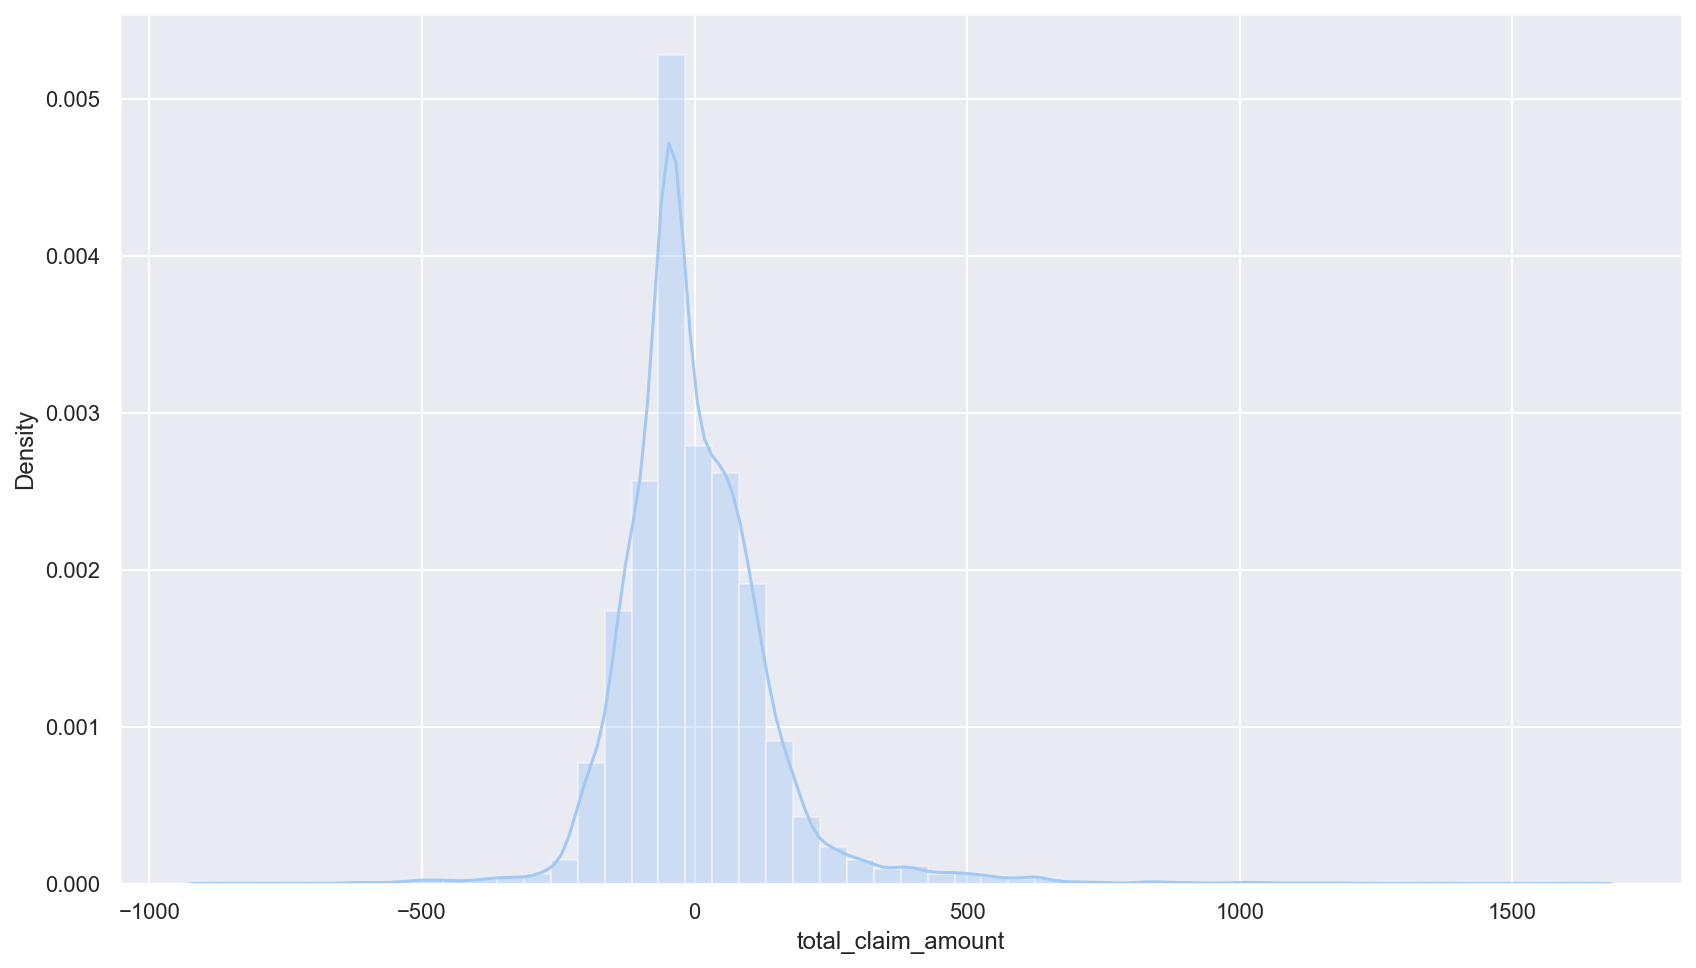

In [40]:

predictions = reg.predict(numerical_transformer.transform(x)) 
residuals = y - predictions                                   
sns.distplot(residuals)

In [41]:
predictions_test = reg.predict(X_test) 
x = predictions_test[0:20]             
y = y_test[0:20]
t = np.arange(0,x.size)  

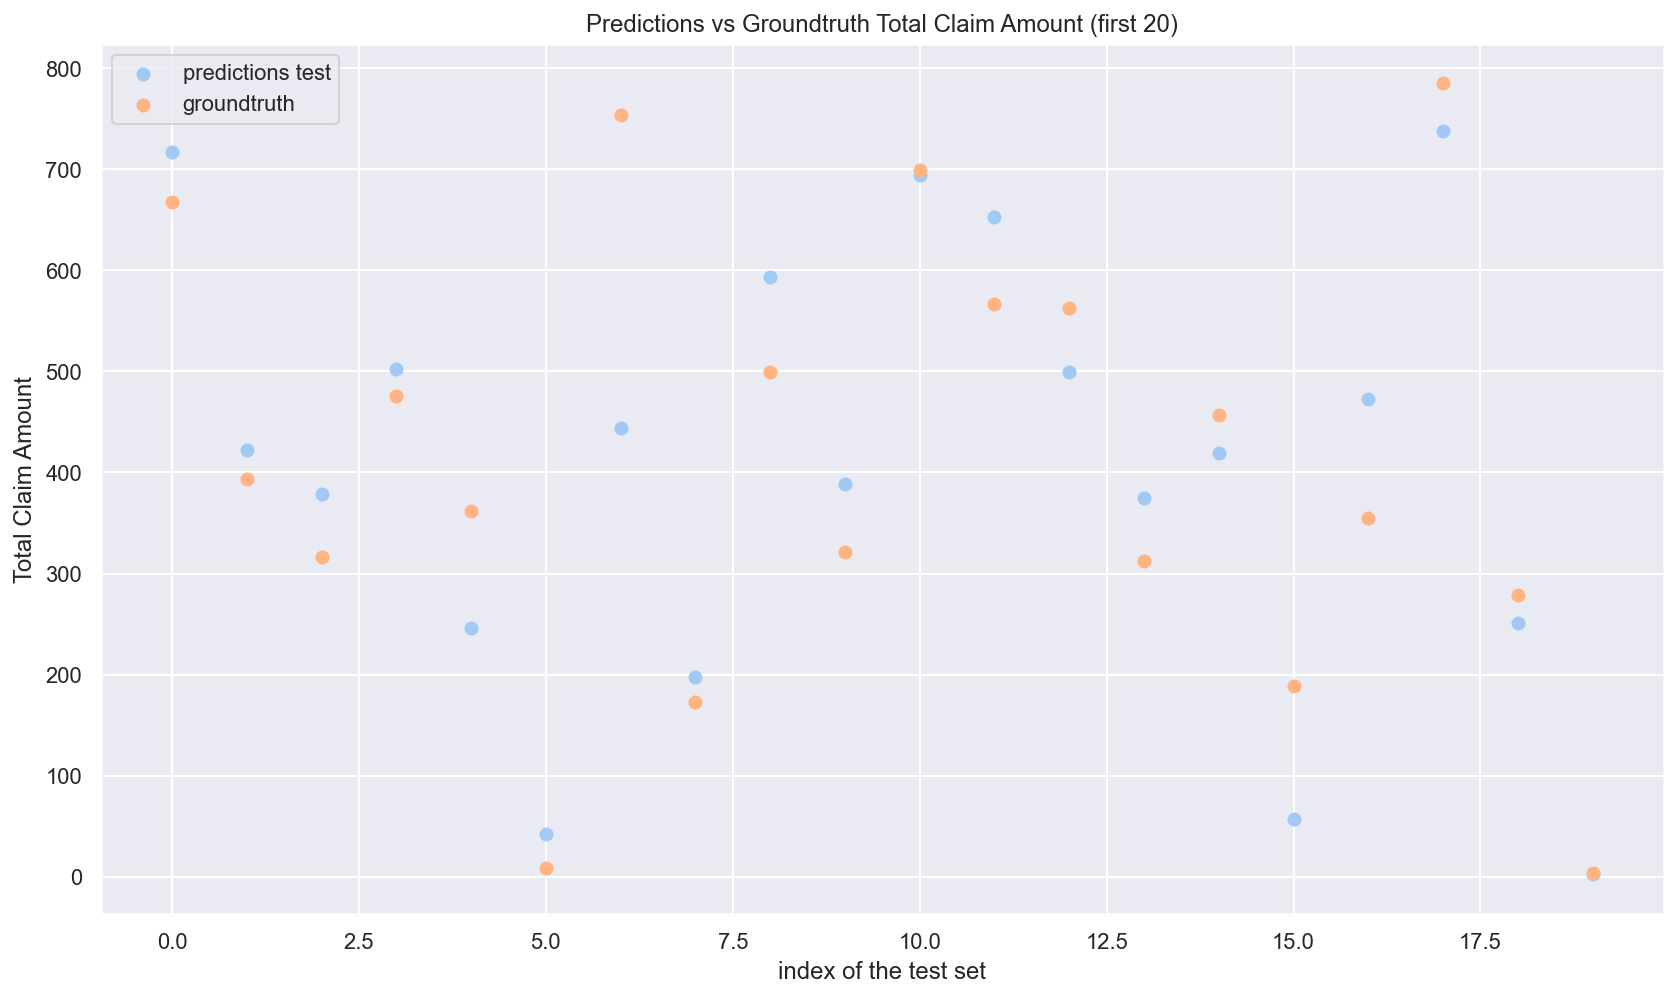

In [42]:
# Create the figure and axes object
fig, ax = plt.subplots()

plt.scatter(t,x) 
plt.scatter(t,y)

# Add Title
plt.title("Predictions vs Groundtruth Total Claim Amount (first 20)") 

# Add Axes Labels
plt.xlabel("index of the test set") 
plt.ylabel("Total Claim Amount") 


# Function add a legend  
plt.legend(["predictions test", "groundtruth"], loc ="best")

# Display
plt.show()